# Bayesian Linear Regression

Quick demonstration of Bayesian linear regression -- particularly, I want to show how you can find the parameters of a Gaussian distribution from which you can sample weights to fit your dataset! Then you can use this distribution as a prior to find the predictive distribution and make use of confidence levels. I will try to explain everything I'm doing, but you should know linear regression, some linear algebra and some Bayesian stats.

## Notation

Lowercase unweighted $x$ means scalar, lowercase bold $\mathbf{x}$ is a vector, and uppercase bold $\mathbf{X}$ is a matrix.

I may refer to density functions as distributions.

### Disclaimer 
Most of this was done as part of my homework for one of my classess taught by Dr Marc Deisenroth at Imperial College London, and it borrows a lot from his notes. A lot of this is also covered in Bishop's "Pattern Recognition and Machine Learning" book. $_{\text{I partly wanted to share it because I thought the plots look cool.}}$

## Imports

In [1]:
# These are actually all the imports we need
import numpy as np # For calculations and linear algebra
import matplotlib.pyplot as plt # For plotting

# Some settings to make the figures more readable 
%matplotlib inline 
from pylab import rcParams
rcParams['figure.figsize'] = 20, 15 # Bigger figures
rcParams.update({'font.size': 25}) # Bigger text (for labels)
from warnings import filterwarnings
filterwarnings('ignore')

## Generating the data

I will create some data to use linear regression on.

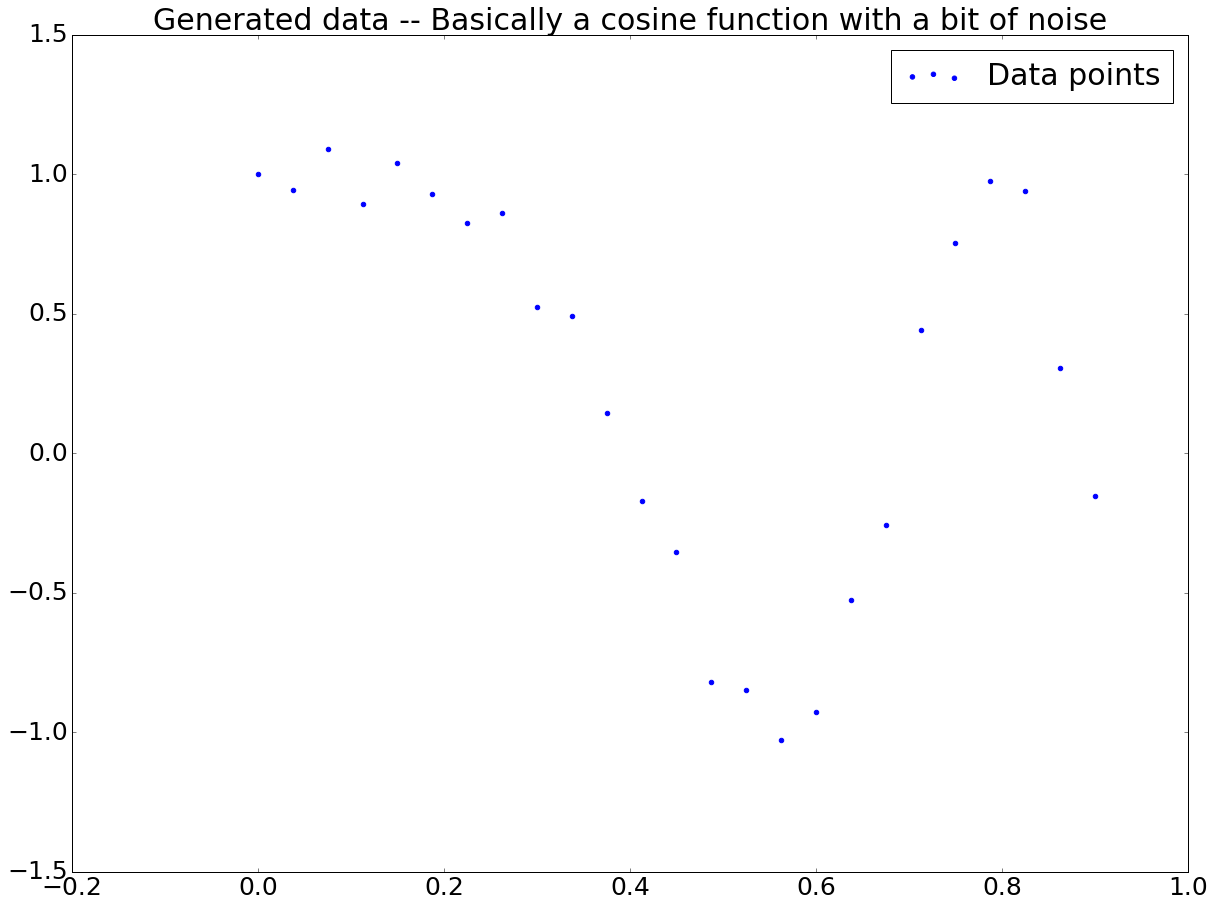

In [2]:
N = 25 # Number of data points
x = np.reshape(np.linspace(0, 0.9, N), (N, 1)) # Generate N points between 0 and 0.9
y = np.cos(10*x**2) + 0.1 * np.sin(100*x) # Generate a `y` value for each of the points above
                                                                   # while adding a bit of noise to each of them (the second term)
def plot_it(title):
    plt.scatter(x, y, color='blue', label='Data points')
    plt.title(title)
    plt.legend()
    plt.show()
    
plot_it('Generated data -- Basically a cosine function with a bit of noise')

## Quick background info

So linear regression is about fitting data points using a function that is linear of $\mathbf{w}$, where $\mathbf{w} \in \mathbb{R}^D$ are the weights of the input $\mathbf{x} \in \mathbb{R}^D$. Simplest example where $x$ is one-dimensional:

$$f(x, \mathbf{w}) = w_0 + w_1x$$


However, we can make a stronger model by adding a nonlinear function $g$ of $x$ to the $f$ function (think polynomial regression):

$$f(x, \mathbf{w}) = w_0 + w_1x + w_2g(x)$$

This may be further extended by having as many $g$ functions as we want. To generalise the formula, we may want to write it as follows:

$$f(x, \mathbf{w}) = w_0 + \sum_{i=1}^{D-1}w_ig_i(x) = \mathbf{w}^T\mathbf{g}(x)$$

(I eliminated $w_0$ (the bias) by assuming a $g_0(x) =1$)

Awesome, now let's define our $\mathbf{g}$ functions to be Gaussian functions with different means.

In [3]:
def gaussian(x, mean, scale):
    """Enhance x with Gaussian features 
    
    Args:
        x (list): list of 1-dimensional observations
        mean (list): list of means for the Gaussian functions
        scale (float): variance for the Gaussian functions"""
    return np.array(np.append(np.ones(x.shape[0]), # Add bias
                              np.array([np.exp(-(x-mu) ** 2/(2 * scale ** 2)) for mu in mean])).reshape(1+ len(mean), len(x)).T)

The code above just implements a Gaussian function. It's not very pretty because the details are not very important: it's just this:

$$ g_i(x) = \exp{(-\frac{(x-\mu_i)^2}{2\sigma^2})} $$

where `mean` is $\mu$ and `scale` is $\sigma$.

So basically, you give `gaussian()` a list `x` which contains one-dimensional observations, a list of means and a `scale` float and you get back a matrix where the first column has the bias terms, the second one has the `x` vector provided, the 3rd one has the `x` values passed through a Gaussian function of mean `mean[0]` and scale `scale`, and so on for all means provided.

## Bayesian Formulation

Up until now there's been no Bayesian stuff going on, so here it goes.

Bayes' theorem goes something like this:

$$ \underbrace{p(\mathbf{\theta}|\mathbf{x}, \mathbf{y})}_{posterior} = \frac{p(\mathbf{y}|\mathbf{x},\mathbf{\theta})p(\mathbf{\theta})}{p(\mathbf{y}|\mathbf{x})} \propto \underbrace{p(\mathbf{y}|\mathbf{x},\mathbf{\theta})}_{likelihood}\, \underbrace{p(\mathbf{\theta}}_{prior})$$ 

where $\mathbf{x}$ are the 1-dimensional observations, $\mathbf{y}$ are the labels ($y_i$ is the label of $x_i$) and $\mathbf{\theta}$ are the parameters.

Great, so what we're interested in is the posterior $p(\mathbf{\theta}|\mathbf{x},\mathbf{y})$ so we have to figure out the likelihood and the prior.

From a probabilistic perspective, linear regression can be formulated as:

$$ y = f(x) + \epsilon $$

where $\epsilon \sim \mathcal{N}(0, \sigma^2)$. Therefore, assuming our $f(x,\mathbf{w})$ defined previously, we have

$$ y = \mathbf{w}^T\mathbf{g}(x) + \epsilon $$

Therefore, adding a constant to a Gaussian random variable results in a shift of the mean (from 0 to $\mathbf{w}^T\mathbf{g}(x)$), so we can say that $p(\mathbf{y}|\mathbf{x},\mathbf{w}) \sim \mathcal{N}(\mathbf{w}^T\mathbf{g}(x), \sigma^2)$.

## Maximum Likelihood

For those familiar with point estimates, one may take the maximum likelihood estimate (MLE) for $\mathbf{w}$ and find the $\mathbf{w}$ that maximises the likelihood $p(\mathbf{y}|\mathbf{x},\mathbf{w})$ and just treat this as an unconstrained optimisation problem:


$$\text{argmax}_{\mathbf{w} \in \mathbb{R}^N}\,p(\mathbf{y}|\mathbf{x},\mathbf{w})$$

(GitHub doesn't seem to render $\text{argmax}$ properly when using `\underset`)



For linear regression, there's a closed-form solution for $\theta_{MLE} = \mathbf{(X^TX)^{-1}X^Ty}$. If you want to check out the full derivation, take a look [here](http://www.dsplog.com/2011/12/04/closed-form-solution-linear-regression/). Similarly, you could just use gradient descent or any other optimisation technique, but because the matrix is small enough to be easily invertible, I'll just go with the closed-form solution.

Using this solution, we can find some $\mathbf{w}$ that maximises the likelihood. For the input matrix, we will use the bias (only ones), the $x$ itself, and 3 other Gaussians with different means and the same scale.


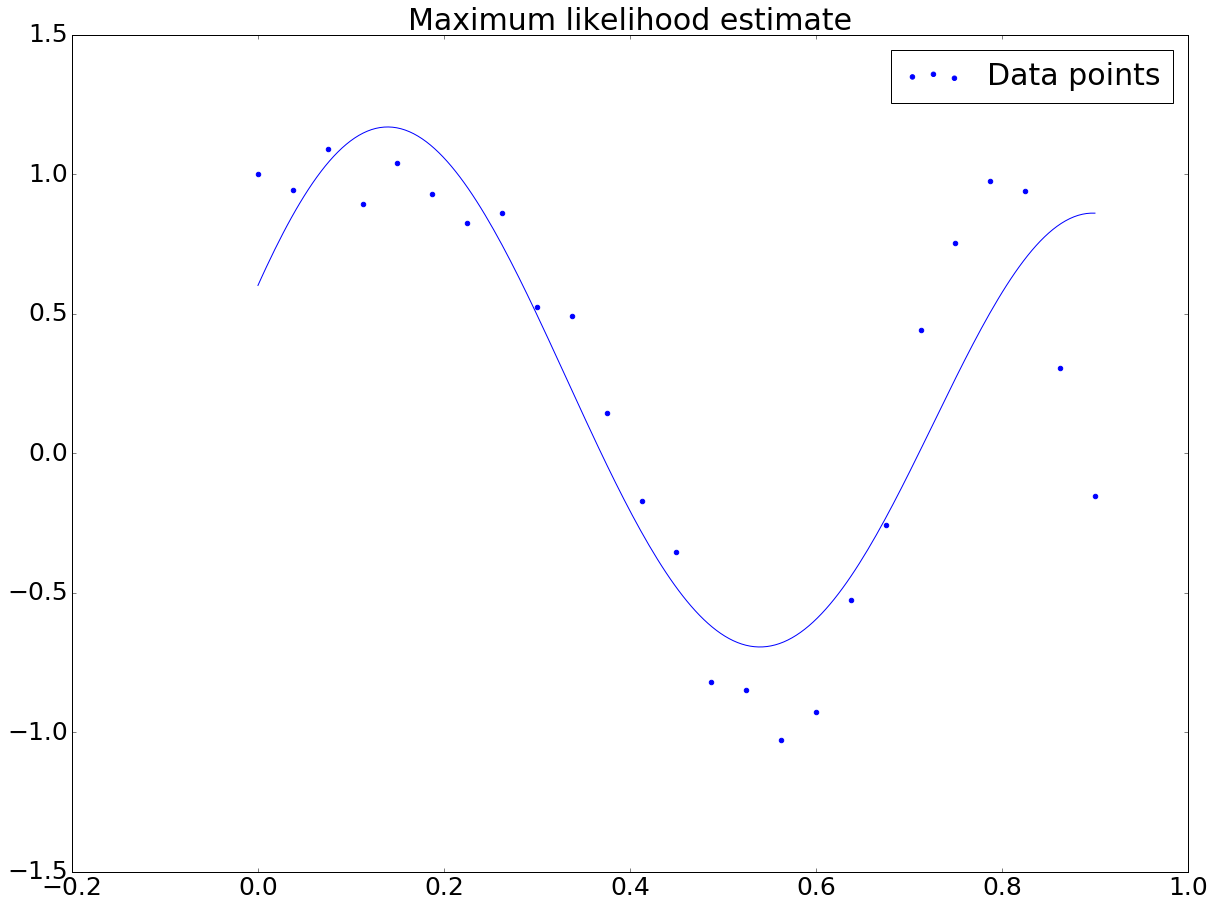

In [4]:
points = np.reshape(np.linspace(0, 0.9, 200), (200, 1)) # Use 200 points for smooth curves
X_200 = gaussian(points, [0.1, 0.3, 0.9], 0.2) # Make a matrix using 3 different Gaussians.
                                                                       # Note that different parameters lead to different results
y_200 = np.cos(10*points**2) + 0.1 * np.sin(100*points) # Generate the equivalent targets
w = np.linalg.inv(X_200.T @ X_200) @ X_200.T @ y_200 # `@` is matrix multiplication
plt.plot(points, X_200 @ w) # Xw rather than w^Tx because X is now a vector of all data points
plot_it('Maximum likelihood estimate')

Great, but point estimates is not why we're here. We're here to calculate the full posterior, not just some fixed values.

## Posterior parameters

Remember:

$$ \underbrace{p(\mathbf{w}|\mathbf{x}, \mathbf{y})}_{posterior} \propto \underbrace{p(\mathbf{y}|\mathbf{x},\mathbf{w})}_{likelihood}\, \underbrace{p(\mathbf{w}}_{prior})$$ 

We have the likelihood, so let's also set a prior (which is identical to setting a regularization term). To keep the calculation of the posterior tractable, we'll look for a conjugate prior, so in our case we can just use another Gaussian distribution for the prior $p(\mathbf{w}) \sim \mathcal{N}(\mathbf{m}, \mathbf{S})$. Note that after setting the prior you could calculate the maximum a posteriori (MAP) estimation (Ridge regression), but then again -- that will only lead to one point estimate, rather than finding entire distribution of parameters.

So for now, we want to compute the product between 2 Gaussian distributions: the likelihood and the prior.

$$\mathcal{N}(\mathbf{y}|\mathbf{g}(\mathbf{x})\mathbf{w},\sigma^2\mathbf{I})\mathcal{N}(\mathbf{w}|\mathbf{m},\mathbf{S}))$$

where $\mathbf{I}$ is the identitiy matrix, and I made $\mathbf{w}^T\mathbf{g}(x)$ into $\mathbf{g(x)}\mathbf{w}$ (note that $\mathbf{x}$ is now a vector because I'm considering the entire dataset, rather than one data point.) To make the notation simpler, I will replace $\mathbf{g(x)}$ with the matrix $\mathbf{\Phi}$, so we have:

$$\mathcal{N}(\mathbf{y}|\mathbf{\Phi}\mathbf{w},\sigma^2\mathbf{I})\mathcal{N}(\mathbf{w}|\mathbf{m},\mathbf{S}))$$

Now, you can multiply Gaussian distributions if they have the "right form" i.e.

$$ \mathcal{N}(\mathbf{x}|\mathbf{a}, \mathbf{A}) \mathcal{N}(\mathbf{x}|\mathbf{b}, \mathbf{B}) $$

results in an unnormalized Gaussian distribution $c\mathcal{N}(\mathbf{x}|\mathbf{c}, \mathbf{C})$ where

$$\mathbf{C} = (\mathbf{A}^{-1} + \mathbf{B}^{-1})^{-1} $$

and 

$$\mathbf{c} = \mathbf{C}(\mathbf{A}^{-1}\mathbf{a} + \mathbf{B}^{-1}\mathbf{b})$$

Well, our product does not have the right form, so we'll need to do some slight modifications to the likelihood to show us how $\mathbf{w}$ is distributed instead of $\mathbf{y}$:

$$\mathcal{N}(\mathbf{y}|\mathbf{\Phi}\mathbf{w},\sigma^2\mathbf{I})$$

Swapping $\mathbf{y}$ with $\mathbf{\Phi}\mathbf{w}$:

$$\mathcal{N}(\mathbf{\Phi}\mathbf{w}|\mathbf{y},\sigma^2\mathbf{I})$$

I can do this because if you remember the Gaussian formula, you have $\mathbf{x}$ and $\mathbf{\Phi}\mathbf{w}$ as $(\mathbf{x} - \mathbf{\Phi}\mathbf{w})^2$ so the order doesn't matter.

Scaling by $\Phi^T$:

$$\mathcal{N}(\mathbf{\Phi}^T\mathbf{\Phi}\mathbf{w}|\mathbf{\Phi}^T\mathbf{y},\sigma^2\mathbf{\Phi}^T\mathbf{\Phi})$$

Note that to find the new covariance, I used the affine transformation for multivariate Gaussian -- there's a proof [here](http://math.stackexchange.com/a/332722/292199). 

Now that we know $\mathbf{\Phi}^T\mathbf{\Phi}$ is a square matrix, we can multiply by its inverse to get rid of it:

$$\mathcal{N}((\mathbf{\Phi}^T\mathbf{\Phi})^{-1}\mathbf{\Phi}^T\mathbf{\Phi}\mathbf{w}|(\mathbf{\Phi}^T\mathbf{\Phi})^{-1}\mathbf{\Phi}^T\mathbf{y},\sigma^2(\mathbf{\Phi}^T\mathbf{\Phi})^{-1}\mathbf{\Phi}^T\mathbf{\Phi}(\mathbf{\Phi}^T\mathbf{\Phi})^{-1})$$

After we use the definition of an inverse matrix $\mathbf{A}\mathbf{A}^{-1} = \mathbf{I}$ we are left with the following:

$$\mathcal{N}(\mathbf{w}|(\mathbf{\Phi}^T\mathbf{\Phi})^{-1}\mathbf{\Phi}^T\mathbf{y},\sigma^2(\mathbf{\Phi}^T\mathbf{\Phi})^{-1})$$


Right, ok, finally we can find the parameters of the product between our likelihood and prior:
$$\mathcal{N}(\mathbf{w}|(\mathbf{\Phi}^T\mathbf{\Phi})^{-1}\mathbf{\Phi}^T\mathbf{y},\sigma^2(\mathbf{\Phi}^T\mathbf{\Phi})^{-1})\mathcal{N}(\mathbf{w}|\mathbf{m},\mathbf{S})) = \mathcal{N}(\mathbf{w}|\mathbf{m_{post}}, \mathbf{S_{post}})$$

where 
$$ \mathbf{S_{post}} = (\mathbf{S}^{-1} + \sigma^{-2}\mathbf{\Phi}^T\mathbf{\Phi})^{-1} $$

$$ \mathbf{m_{post}} =  \mathbf{S_{post}}(\mathbf{S}^{-1}\mathbf{m} + \sigma^{-2}(\mathbf{\Phi}^T\mathbf{\Phi})(\mathbf{\Phi}^T\mathbf{\Phi})^{-1}\mathbf{\Phi}^T\mathbf{y}) = \mathbf{S_{post}}(\mathbf{S}^{-1}\mathbf{m} +  \sigma^{-2}\mathbf{\Phi}^T\mathbf{y})$$


Wow, okay, now we finally have the parameters of the distribution. Let's set the mean $\mathbf{m}$ of the prior to $\mathbf{0}$ to simplify things a bit:

$$ \mathbf{S_{post}} = (\mathbf{S}^{-1} + \sigma^{-2}\mathbf{\Phi}^T\mathbf{\Phi})^{-1} $$
$$ \mathbf{m_{post}} = \mathbf{S_{post}}(\sigma^{-2}\mathbf{\Phi}^T\mathbf{y})$$

Remember that $\sigma$ was introduced when we defined the distribution of the noise $\epsilon$, so it's just the variance of the noise. Also, for simplicity we can set $\mathbf{S}$ to be the identity matrix.

In [5]:
# Generate a matrix X with 10 Gaussian functions
X = gaussian(x, np.linspace(-0.5, 1, 10), 0.1)
# I'll just set S to the identity matrix
S = np.identity(x.shape[1])
# Set the noise to a a parameter
sigma = np.sqrt(0.2)

# Posterior parameters
S_post = np.linalg.inv(np.linalg.inv(S) + sigma ** (-2) * X.T @ X)
m_post = S_post @ (sigma ** (-2) * X.T @ y)

### Sampling from the posterior

Now let's just sample some weights, predict data with them, and plot the results:

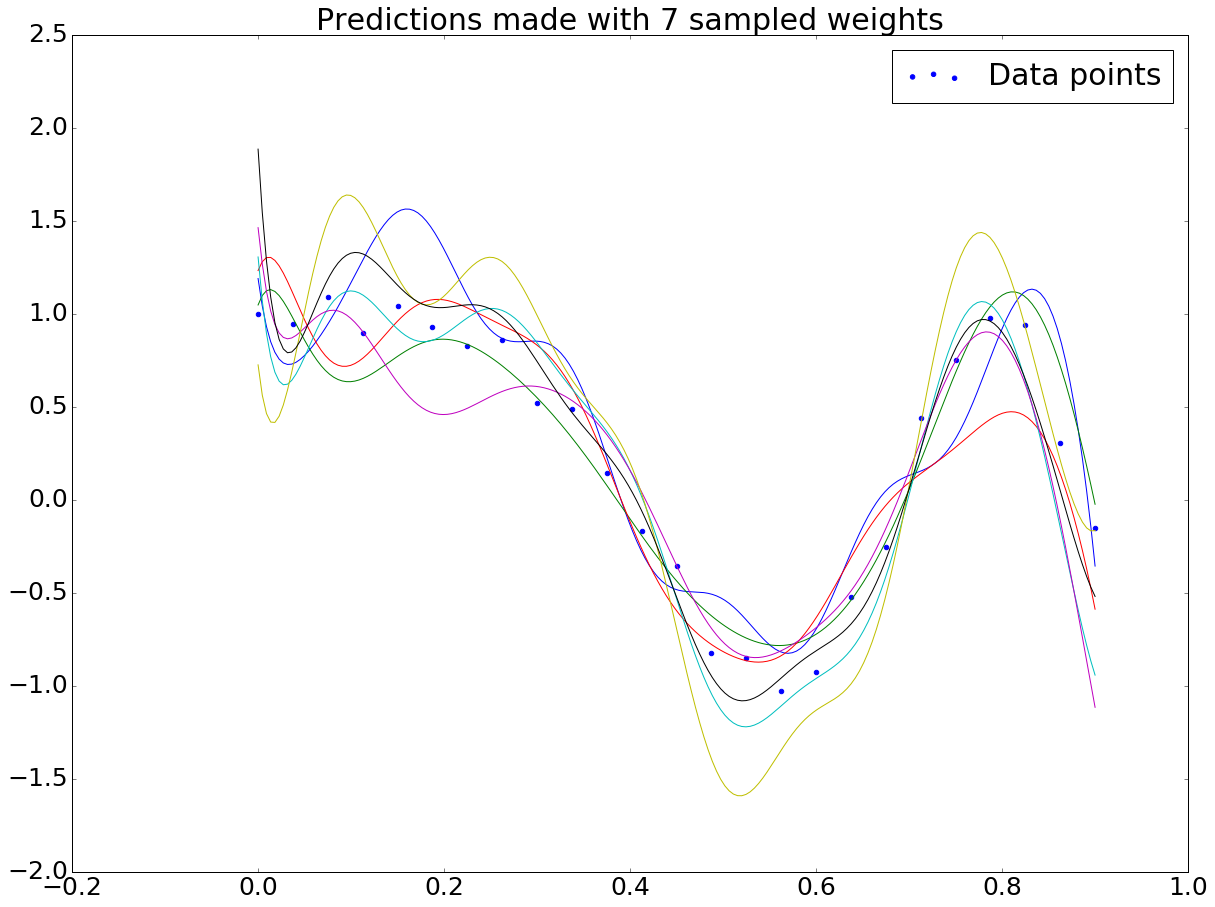

In [6]:
n_weights = 7
X_200 = gaussian(points, np.linspace(-0.5, 1, 10), 0.1)
def plot_some_functions(n_weights):
    for _ in range(n_weights):
        sampled_w = np.random.multivariate_normal(m_post.reshape(11,), S_post)
        plt.plot(points, X_200 @ sampled_w)
plot_some_functions(n_weights)   
plot_it('Predictions made with {} sampled weights'.format(n_weights))

## Predictive distribution 

Right, but now we need to find the predictive distribution $p(y^*)$ where $y^*$ is the prediction for an unseen value $x^*$.

We know that for the general case, the marginal distribution looks something like:

$$ p(y) = \int p(y|x)p(x) $$

In our case, we have something like this $y^* = \mathbf{w}^T\mathbf{g}(x^*) + \epsilon$ and we want to find out

$$ p(y^*|\mathbf{X}, \mathbf{y}, x^*) = \int p(y^*|x^*, \mathbf{w}) p(\mathbf{w}|\mathbf{X},\mathbf{y})d\mathbf{w} $$

So the first factor is the likelihood, and the second one is the prior (which is also the posterior that we just calculated previously) and we have something like this:

$$ p(y^*|\mathbf{X}, \mathbf{y}, x^*) = \int \mathcal{N}(y^*|\mathbf{w}^T\mathbf{g}(x^*), \sigma^2)\mathcal{N}(\mathbf{w}|\mathbf{m}_{post}, \mathbf{S}_{post})$$

Great, now Bishop has this nice formula in *2.3.3. Bayes' theorem for Gaussian variables* that can help solve the above equation:

If $p(\mathbf{x}) = \mathcal{N}(\mathbf{x}|\mathbf{\mu}, \mathbf{K})$ and $p(\mathbf{y}|\mathbf{x})=\mathcal{N}(\mathbf{y}|\mathbf{A}\mathbf{x}, \mathbf{L})$, then:

$$p(\mathbf{y})=\mathcal{N}(\mathbf{y}|\mathbf{A}\mathbf{\mu}, \mathbf{L} + \mathbf{A}\mathbf{K}\mathbf{A}^T)$$

In our case, applying the above formula returns the following:

$$ p(y^*|\mathbf{X}, \mathbf{y}, x^*) = \mathcal{N}(y^*|\mathbf{m}_{post}^T\mathbf{g}(x^*), \mathbf{g}^T(x^*)\mathbf{S}_{post}\mathbf{g}(x^*) + \sigma^2)$$

Remember that if $x \in \mathbb{R}^N$, then $\mathbf{g}(x)$ becomes $\mathbf{\Phi}$ which is a matrix, and this is what we will work with in the code.

Alright, cool, now we have the parameters of the predictive distribution, and we can finally have some $^{\text{f}}u_{\text{n}}$ (it started)


### Predictive mean

Let's plot out the mean of that predictive distribution as calculated above. This is actually the MAP estimate (fun fact).

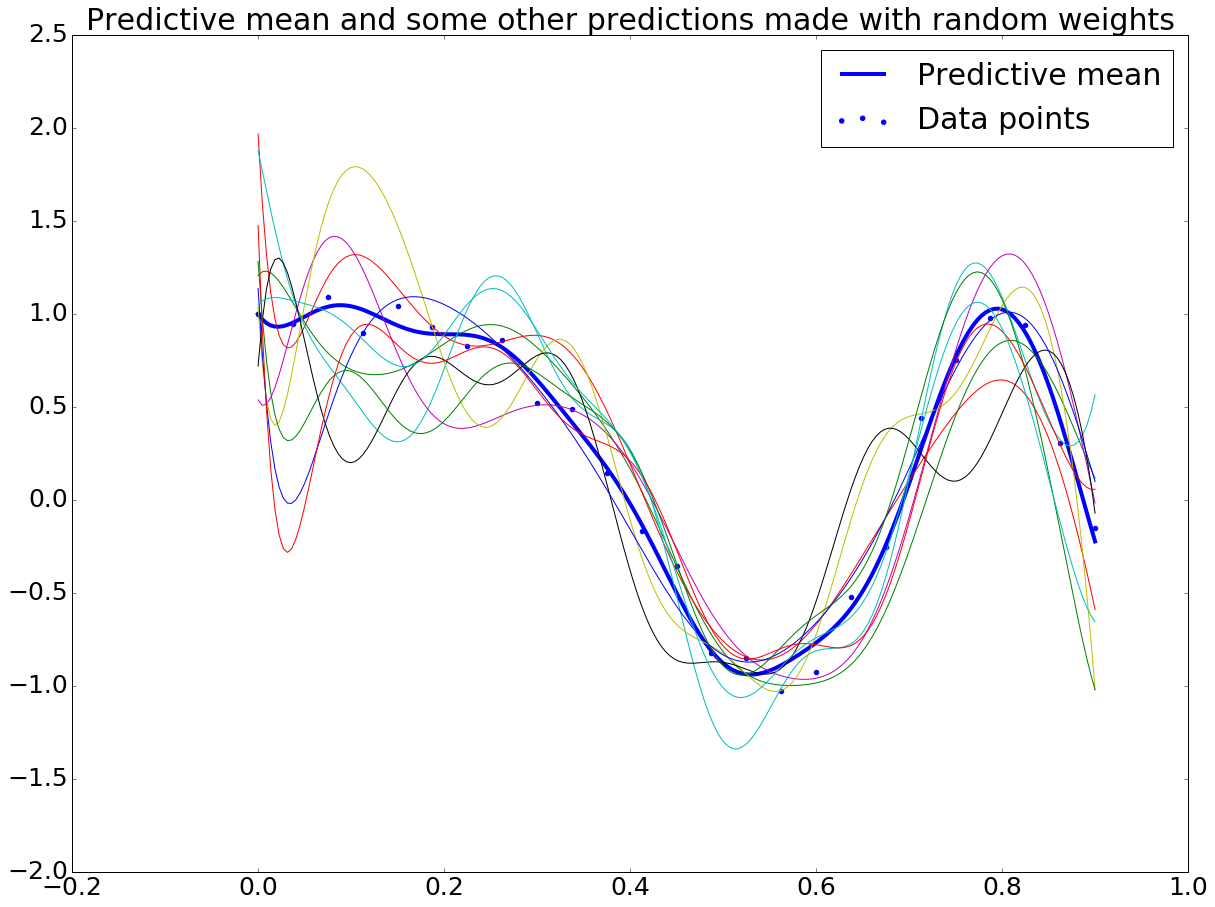

In [7]:
pred_mean = X_200 @ m_post

plt.plot(points, pred_mean, label='Predictive mean', linewidth=4)
plot_some_functions(10)    
plot_it('Predictive mean and some other predictions made with random weights')

Looks awesome. Now let's use that variance parameter and do some confidence levels!

### Confidence level

Given that we know the variance of our distribution, we can plot the area within 2 standard deviations (95% confidence). Note that our variance is $ \mathbf{\Phi}^T\mathbf{S}_{post}\mathbf{\Phi} + \sigma^2$ so we can use both the noiseless variance ($\sigma^2 = 0$), and one with noise.

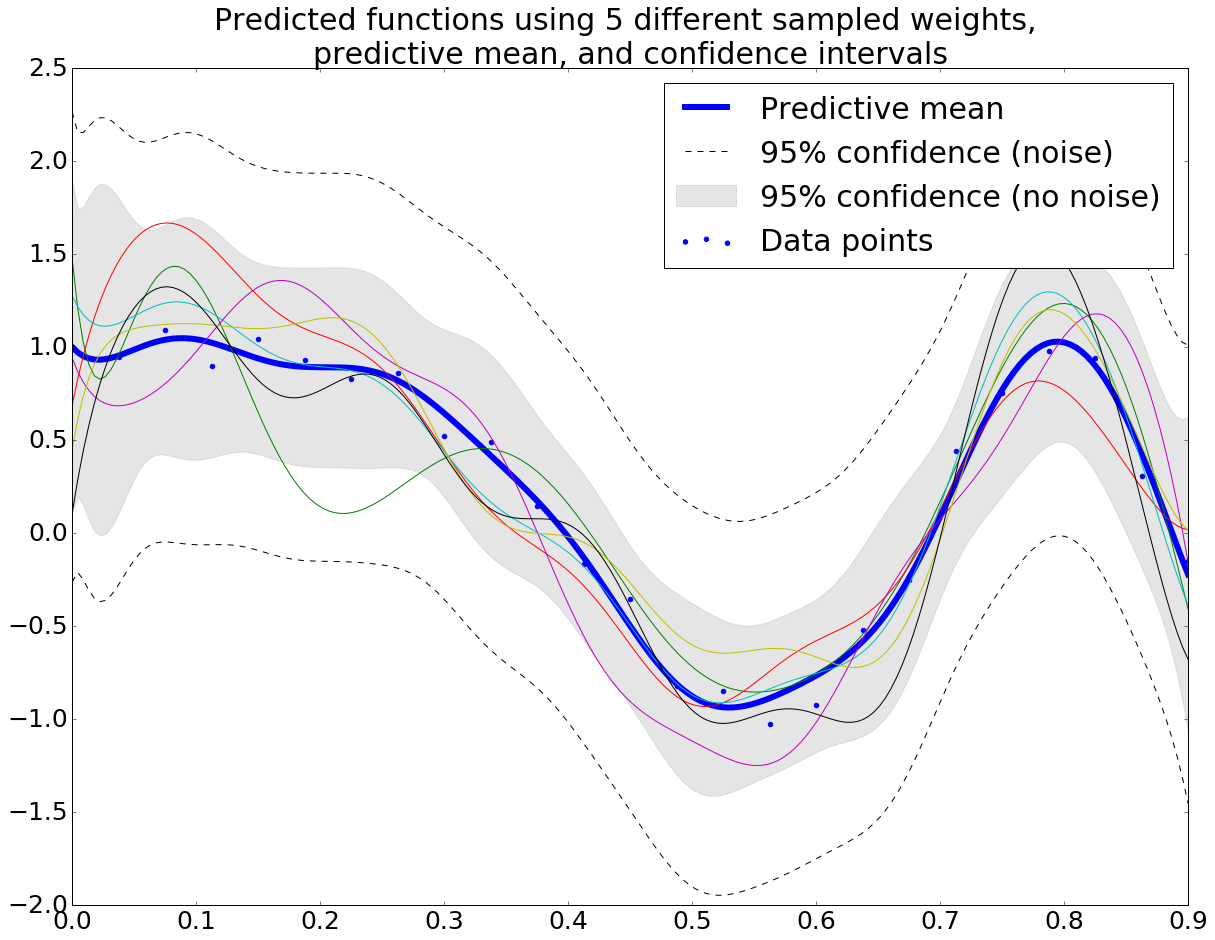

In [8]:
noise = 0.2 
std_noiseless = np.sqrt(X_200 @ S_post @ X_200.T)
std_noise = np.sqrt(std_noiseless ** 2 + noise)
plt.plot(points, pred_mean, label='Predictive mean', linewidth=6)
plot_some_functions(6)

# Confidence levels
plt.fill_between(points.flatten(), pred_mean.flatten() - np.diag(2 * std_noiseless),
                        pred_mean.flatten() + np.diag(2* std_noiseless), color='grey',
                        alpha=0.2, label='95% confidence (no noise)')
plt.plot(points.flatten(), pred_mean.flatten() - np.diag(2 * std_noise), '--', label='95% confidence (noise)', color='black')
plt.plot(points.flatten(), pred_mean.flatten() + np.diag(2 * std_noise), '--', color='black')

plt.xlim(0, 0.9) # Looks better
plt.ylim(-2, 2.5)
plot_it('Predicted functions using 5 different sampled weights, \npredictive mean, and confidence intervals')

## The end

Alright, that's it. Gotta go back to work

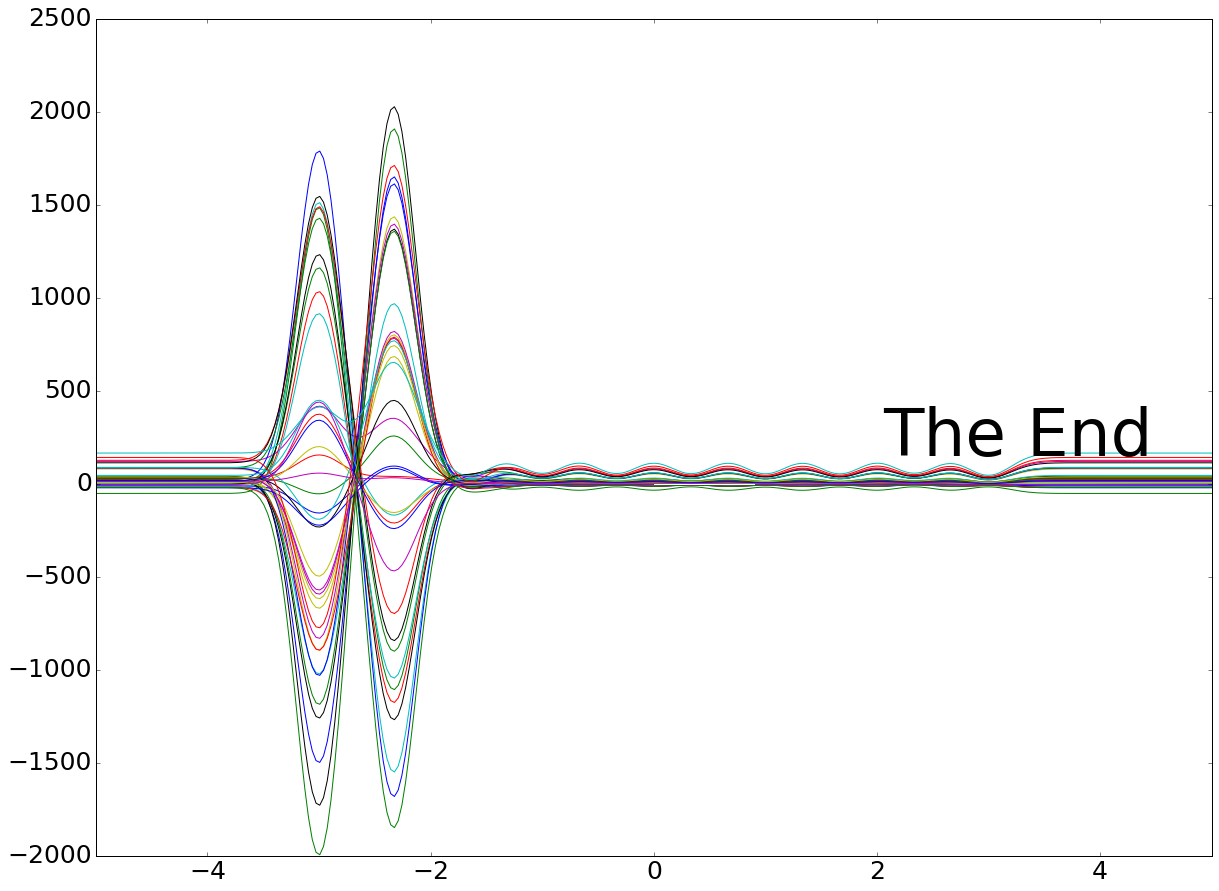

In [9]:
points_end = np.reshape(np.linspace(-5, 5, 300), (300, 1))
X_more = gaussian(points_end, np.linspace(-3, 3, 10), 0.2) 

for _ in range(40):
    sampled_w = np.random.multivariate_normal(m_post.reshape(11,), S_post)
    plt.plot(points_end, X_more @ sampled_w)
    
plt.plot(points, [0] * len(points), label="The End", color='white')
plt.legend(loc=7, prop={'size':66}, framealpha=0)
plt.xlim(-5, 5)
plt.show()